# Offshore Wind
Austin Hancock

### Load data

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
from matplotlib.colors import ListedColormap
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize

C:\Users\ahancock\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [15]:
windFarms = pd.read_csv(
    filepath_or_buffer = 'Windfarms_Offshore_20180712(working).csv',
    sep = ','
)

In [16]:
windFarms.head()

,ID ( = no data),Continent,ISO code (Code ISO 3166.1),Country,State code,Area,City,Name,2nd name,Latitude (WGS84),...,Turbine,Hub height (m),Number of turbines,Total power (kW),Developer,Operator,Owner,Commissioning date (Format: yyyy or yyyymm),Status,Update
0,428,Europe,BE,Belgium,NaN,Offshore,NaN,Thorntonbank,Part 1,51.54,...,5M,94.0,6.0,30450.0,EDF-EN/C-Power NV,C-Power NV,DEME/EDF-EN/Socofe/Nuhma/RWE/,2008/07,Production,25/06/2018
1,729,Europe,DK,Denmark,NaN,Offshore,NaN,Middelgrunden,NaN,55.691,...,B76/2000,64.0,20.0,40000.0,Orsted,Orsted/Middelgrundens Vindmollelaug,Orsted/Middelgrundens Vindmollelaug,2000/12,Production,28/06/2018
2,759,Europe,FI,Finland,NaN,Offshore,NaN,Ajos 1,NaN,65.6584267113501,...,WWD-3-90,90.0,1.0,3000.0,Haminan Energia Oy,Haminan Energia Oy,Haminan Energia Oy,2005/12,Production,12/6/2018
3,760,Europe,FI,Finland,NaN,Offshore,NaN,Ajos 5,NaN,65.650284,...,WWD-3-100,88.0,0.0,0.0,PVO Innopower Oy,NaN,NaN,2007/10,Dismantled,12/6/2018
4,1069,Europe,SE,Sweden,NaN,Offshore,NaN,Utgrunden I,NaN,56.344,...,1.5s,65.0,7.0,10500.0,Vattenfall/Orsted/OX2,Vattenfall,Vattenfall,2006/10,Production,15/01/2018


In [17]:
windFarms.shape

(724, 25)

### Data Exploration

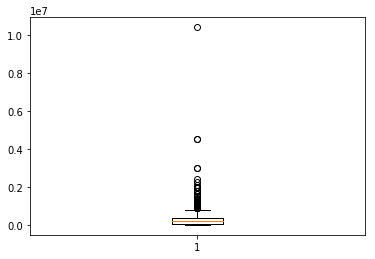

In [18]:
# Total power (kW)
windFarms_Power = windFarms.dropna(subset=['Total power (kW)'])
plt.boxplot(windFarms_Power['Total power (kW)'])
plt.show()

> Need to clean this up

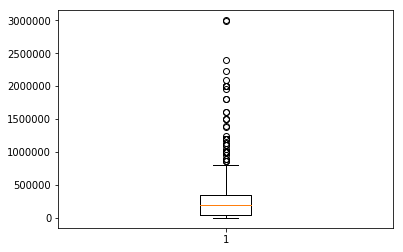

In [19]:
windFarms_Power = windFarms_Power.drop(windFarms_Power[windFarms_Power['Total power (kW)'] > 4000000].index)
windFarms_Power = windFarms_Power.drop(windFarms_Power[windFarms_Power['Total power (kW)'] < 1].index)
plt.boxplot(windFarms_Power['Total power (kW)'])
plt.show()

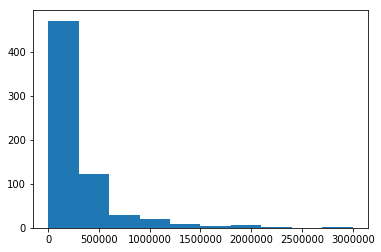

In [20]:
plt.hist(windFarms_Power['Total power (kW)'])
plt.show()

> Need a log transform to fix skewness

In [21]:
windFarms_Power['Total power (kW)'] = np.log(windFarms_Power['Total power (kW)'])

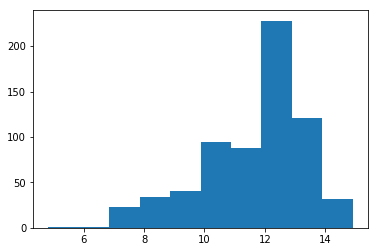

In [22]:
plt.hist(windFarms_Power['Total power (kW)'])
plt.show()

> Looks much better

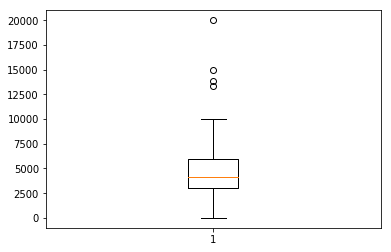

In [23]:
# Average power output per turbines
windFarms_Output = windFarms.copy()
windFarms_Output = windFarms_Output.dropna(subset=['Total power (kW)'])
windFarms_Output = windFarms_Output.dropna(subset=['Number of turbines'])
windFarms_Output['Output/turbine'] = np.where(windFarms_Output['Number of turbines'] < 1, windFarms_Output['Number of turbines'], windFarms_Output['Total power (kW)']/windFarms_Output['Number of turbines'])
plt.boxplot(windFarms_Output['Output/turbine'])
plt.show()

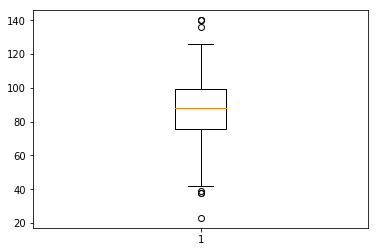

In [24]:
# Hub Height
windFarms_Hub = windFarms.dropna(subset=['Hub height (m)'])
plt.boxplot(windFarms_Hub['Hub height (m)'])
plt.show()

> Looks ok

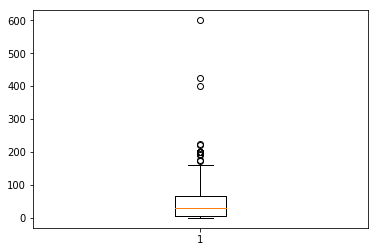

In [25]:
# Number of turbines
windFarms_NumTurbines = windFarms.dropna(subset=['Number of turbines'])
plt.boxplot(windFarms_NumTurbines['Number of turbines'])
plt.show()

> Three very large outliers

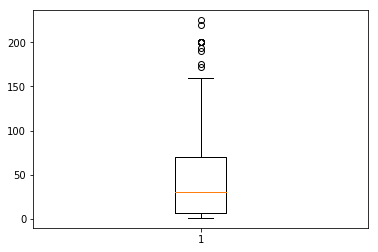

In [26]:
# Drop outliers
windFarms_NumTurbines = windFarms_NumTurbines.drop(windFarms_NumTurbines[windFarms_NumTurbines['Number of turbines'] > 300].index)
# Drop where number of turbines = 0 
windFarms_NumTurbines = windFarms_NumTurbines.drop(windFarms_NumTurbines[windFarms_NumTurbines['Number of turbines'] < 1].index)
plt.boxplot(windFarms_NumTurbines['Number of turbines'])
plt.show()

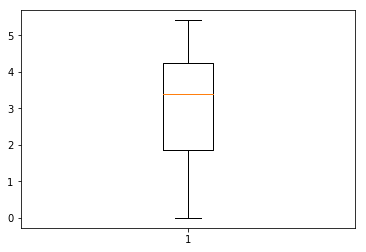

In [27]:
windFarms_NumTurbines['Number of turbines'] = np.log(windFarms_NumTurbines['Number of turbines'])
plt.boxplot(windFarms_NumTurbines['Number of turbines'])
plt.show()

> Looks better after removing outliers

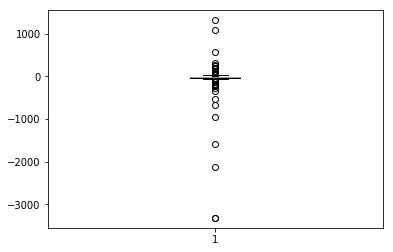

In [28]:
# Depth
windFarms_Depth = windFarms.dropna(subset=['Altitude/Depth (m)'])
plt.boxplot(windFarms_Depth['Altitude/Depth (m)'])
plt.show()

> Large outliers on both sides, this is most likely due to lat lon coordinates being inaccurate

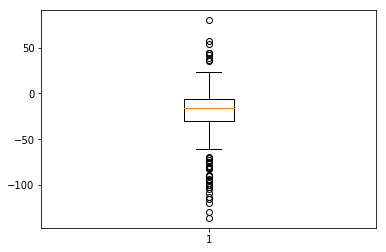

In [29]:
windFarms_Depth = windFarms_Depth.drop(windFarms_Depth[windFarms_Depth['Altitude/Depth (m)'] > 100].index)
windFarms_Depth = windFarms_Depth.drop(windFarms_Depth[windFarms_Depth['Altitude/Depth (m)'] < -150].index)
plt.boxplot(windFarms_Depth['Altitude/Depth (m)'])
plt.show()

> A little better. Without better bathymetry measurements, I'll settle with this for now.

In [30]:
# Make above exploration changes to dataset
windFarms = windFarms.drop(windFarms[windFarms['Number of turbines'] > 300].index)
windFarms = windFarms.drop(windFarms[windFarms['Number of turbines'] < 1].index)
windFarms['Number of turbines'] = np.log(windFarms['Number of turbines'])
windFarms = windFarms.drop(windFarms[windFarms['Altitude/Depth (m)'] > 100].index)
windFarms = windFarms.drop(windFarms[windFarms['Altitude/Depth (m)'] < -150].index)
windFarms = windFarms.drop(windFarms[windFarms['Total power (kW)'] > 4000000].index)
windFarms = windFarms.drop(windFarms[windFarms['Total power (kW)'] < 1].index)
windFarms['Total power (kW)'] = np.log(windFarms['Total power (kW)'])

In [31]:
# Create dummy variables for the categorical data
# Ended up dropping some values that were not helpful to the model

## Continent
#dummies = pd.get_dummies(windFarms['Continent']).rename(columns=lambda x: 'Continent_' + str(x))
#windFarms = pd.concat([windFarms, dummies], axis=1)
#windFarms.drop(['Continent'], inplace=True, axis=1)
## Country
#dummies = pd.get_dummies(windFarms['Country']).rename(columns=lambda x: 'Country_' + str(x))
#windFarms = pd.concat([windFarms, dummies], axis=1)
#windFarms.drop(['Country'], inplace=True, axis=1)
## Manufacturer
dummies = pd.get_dummies(windFarms['Manufacturer']).rename(columns=lambda x: 'Manufacturer_' + str(x))
windFarms = pd.concat([windFarms, dummies], axis=1)
windFarms.drop(['Manufacturer'], inplace=True, axis=1)
## Turbine
dummies = pd.get_dummies(windFarms['Turbine']).rename(columns=lambda x: 'Turbine_' + str(x))
windFarms = pd.concat([windFarms, dummies], axis=1)
windFarms.drop(['Turbine'], inplace=True, axis=1)
## Developer
#dummies = pd.get_dummies(windFarms['Developer']).rename(columns=lambda x: 'Developer_' + str(x))
#windFarms = pd.concat([windFarms, dummies], axis=1)
#windFarms.drop(['Developer'], inplace=True, axis=1)
## Operator
#dummies = pd.get_dummies(windFarms['Operator']).rename(columns=lambda x: 'Operator_' + str(x))
#windFarms = pd.concat([windFarms, dummies], axis=1)
#windFarms.drop(['Operator'], inplace=True, axis=1)
## Owner
#dummies = pd.get_dummies(windFarms['Owner']).rename(columns=lambda x: 'Owner_' + str(x))
#windFarms = pd.concat([windFarms, dummies], axis=1)
#windFarms.drop(['Owner'], inplace=True, axis=1)
## Status
dummies = pd.get_dummies(windFarms['Status']).rename(columns=lambda x: 'Status_' + str(x))
windFarms = pd.concat([windFarms, dummies], axis=1)
windFarms.drop(['Status'], inplace=True, axis=1)

In [32]:
windFarms.shape

(679, 141)

In [33]:
# Remove fields I won't be using
excludeFields = ['ID ( = no data)', 'Continent', 'ISO code (Code ISO 3166.1)', 'Country', 'State code', 'Area', 
                 'City', 'Name', '2nd name', 'Latitude (WGS84)', 'Longitude (WGS84)', 
                 'Location accuracy (Yes = accurate location)', 'Offshore - Shore distance (km)', 'Developer', 
                 'Operator', 'Owner', 'Commissioning date (Format: yyyy or yyyymm)', 'Update']

keepFields = [col for col in windFarms.columns if col not in excludeFields]

windFarms = windFarms[keepFields]

windFarms.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679 entries, 0 to 723
Columns: 123 entries, Altitude/Depth (m) to Status_Production
dtypes: float64(4), uint8(119)
memory usage: 105.4 KB


In [34]:
windFarms.shape

(679, 123)

### Missing Data

Initial dataset from WindPower.net was missing a lot of depth measurements (56% missing).
I used a tool from www.geoplaner.com to fill these missing depths using latitude and longitude coordinates.

In [35]:
# Review missing vals
missing_values = windFarms.isnull().sum().reset_index()
missing_values.columns = ['Variable Name', 'Number Missing Values']
missing_values = missing_values[missing_values['Number Missing Values'] > 0] 

#Print all rows with missing values
with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
    print(missing_values)

        Variable Name  Number Missing Values
0  Altitude/Depth (m)                     45
1      Hub height (m)                    507
2  Number of turbines                    266
3    Total power (kW)                     36


In [36]:
#Check for missing values
windFarmsS = windFarms.copy()
Temp = pd.DataFrame(windFarmsS.isnull().sum())
#print(Temp)
Temp.columns =['DataMissing']
#Columns with at least 1 missing value
MissingCount = Temp[Temp.DataMissing>0]

#sort 
MissingCount = MissingCount.sort_values('DataMissing',ascending=False)
#basic stats on missing data
print("##################################################")
print("###", '             Stats on missing data        ',  "###")
print("##################################################")
print('No. of rows in windFarmsS: ',len(windFarmsS))
print('No. of Columns in windFarmsS: ',len(windFarmsS.columns))
print('No. of Columns with Missing data: ',len(MissingCount))
print('No. of Complete data columns: ', len(windFarmsS.columns) - len(MissingCount))
print('No. of Columns with 100% missing Values: ',sum(1 for item in MissingCount.DataMissing if item==len(windFarmsS)))
print('% of Columns with some Missing data: ',round(float(100*len(MissingCount))/len(windFarmsS.columns),3),'%')
print('% of Columns with 100% Missing data: ',round(float(100*sum(1 for item in MissingCount.DataMissing if item==len(windFarmsS)))/len(windFarmsS.columns),3),'%')

print(" ")
print("##################################################")
print("###",'       Columns with  missing data     ',    "###")
print("##################################################")
#add a columnName for Bar charts plot
MissingCount['ColumnName'] = MissingCount.index
MissingCount['Missing %'] = 100*(MissingCount.DataMissing/len(windFarmsS))
MissingCount = MissingCount.reset_index()
del MissingCount['index']
print((MissingCount.head(100)))

##################################################
###              Stats on missing data         ###
##################################################
No. of rows in windFarmsS:  679
No. of Columns in windFarmsS:  123
No. of Columns with Missing data:  4
No. of Complete data columns:  119
No. of Columns with 100% missing Values:  0
% of Columns with some Missing data:  3.252 %
% of Columns with 100% Missing data:  0.0 %
 
##################################################
###        Columns with  missing data      ###
##################################################
   DataMissing          ColumnName  Missing %
0          507      Hub height (m)  74.668630
1          266  Number of turbines  39.175258
2           45  Altitude/Depth (m)   6.627393
3           36    Total power (kW)   5.301915


> Missing a lot of Hub height data, future exploration could include researching turbine types and manufacturers to see if these values can be located.

#### Two different ways of handling missing

In [37]:
# Drop missing
#windFarms = windFarms.dropna(subset=['Hub height (m)'])
windFarms = windFarms.dropna(subset=['Total power (kW)']) #Dropping missing since this is the response

In [38]:
# Fill in missing with avg
#this function replaces NA's for columns with continous 'Con' (int or float) variables with median and categorical 'Cat' variable(bool or object) with mode
def ReplaceMissingdata(df):
    temp_df = df.copy() 
    print("########################################")
    print("## continuous and categorical columns ##")
    print("########################################")
    temp  = df.select_dtypes(include=['int64','float'])    #continuous values columns
    columnnames = temp.columns
    temp1  = df.select_dtypes(include=['object','bool']) #categorical values columns
    columnnames1 = temp1.columns
    print(" ")
    
    print("##############################")
    print("## NA count Before Cleaning ##")
    print("##############################")
    print(df.isnull().sum())
    #replacing missing continous values with median
    for i in range(0,len(columnnames)):
        try:
            temp_array =temp[temp[columnnames[i]]!=np.nan][columnnames[i]] #temp array of non NAs for continous values to calculate median
            # replace NAs with median for continous variables created from above arrays
            temp_df[columnnames[i]] =temp_df[columnnames[i]].replace(np.nan,temp_array.median())     
        except Exception as e:
            print(e.args) 
            
    #replacing missing contegorical values with mode
    for i in range(0,len(columnnames1)):
        try:
            temp_array1 =temp1[temp1[columnnames1[i]]!=np.nan][columnnames1[i]] #temp array of non NAs for categorical values to calculate mode
            # replace NAs with median for categorical values created from above arrays with mode
            temp_df[columnnames1[i]] =temp_df[columnnames1[i]].replace(np.nan,str(temp_array1.mode()[0]))      
        except Exception as e:
            print(e.args)

    print("##############################")
    print("## NA Count After Cleaning  ##")
    print("##############################")
    print(temp_df.isnull().sum())
    df = temp_df
    return df

windFarms_Clean = ReplaceMissingdata(windFarms)    

windFarms_Clean.info()

########################################
## continuous and categorical columns ##
########################################
 
##############################
## NA count Before Cleaning ##
##############################
Altitude/Depth (m)                             34
Hub height (m)                                471
Number of turbines                            235
Total power (kW)                                0
Manufacturer_Adwen                              0
Manufacturer_Alstom Power                       0
Manufacturer_Areva                              0
Manufacturer_Bard                               0
Manufacturer_Bonus                              0
Manufacturer_CSIC HZ Windpower                  0
Manufacturer_China Creative Wind Energy         0
Manufacturer_Dongfang Electric Corporation      0
Manufacturer_Doosan                             0
Manufacturer_Enercon                            0
Manufacturer_Envision                           0
Manufacturer_GE Energy          

In [39]:
# Scale data
# Tried scaling, results were much worse

## Hub height (m)
#windFarms_Clean['Hub height (m)'] = preprocessing.scale(windFarms_Clean['Hub height (m)'])
## Number of Turbines
#windFarms_Clean['Number of turbines'] = preprocessing.scale(windFarms_Clean['Number of turbines'])
## Total Power kW
#windFarms_Clean['Total power (kW)'] = preprocessing.scale(windFarms_Clean['Total power (kW)'])
## Altitude/Depth (m)
#windFarms_Clean['Altitude/Depth (m)'] = preprocessing.scale(windFarms_Clean['Altitude/Depth (m)'])

In [40]:
windFarms_Clean.shape

(643, 123)

In [41]:
## Correlation matrix: Didn't run in final report because it changes the format of other graphics, not very helpful anyway

#%%time
#%matplotlib inline
#temp = windFarms_Clean.select_dtypes(include=['int','float', 'uint8']) # select int to run corr on
#print(temp.shape)
#
## calculate the correlation matrix
#corr_matrix  = temp.corr()#.abs()
#
## Select upper triangle of correlation matrix
#upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
#
## Find index of feature columns with correlation greater than 0.95
#to_drop = [column for column in upper.columns if any(upper[column] > 0.05)]
#
#fig, ax = plt.subplots(figsize=(60,60))
#sns.set(font_scale=3)
#sns.heatmap(upper[to_drop], 
#            #xticklabels=upper[to_drop].columns.values,
#            #yticklabels=upper[to_drop].columns.values,
#            linewidths=.5, ax=ax)

In [42]:
windFarms_Final = windFarms_Clean.copy()

In [43]:
windFarms_Final.shape

(643, 123)

## Modeling

### Linear Regression

In [44]:
# Two methods: 
#   1) Use all variables
#   2) Select only certain variables

### All variables
## Drop response var from dataset
#modelingData = windFarms_Final.copy()
#modelingData.pop('Total power (kW)')
#print(modelingData.shape)
#y = windFarms_Final['Total power (kW)']
#print(y.shape)


### Only some variables (better model)
modelingData = windFarms_Final[['Number of turbines', 'Altitude/Depth (m)', 'Hub height (m)']]
print(modelingData.shape)
y = windFarms_Final['Total power (kW)']
print(y.shape)

(643, 3)
(643,)


In [45]:
# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(modelingData, y, test_size=0.3)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(450, 3) (450,)
(193, 3) (193,)


In [46]:
# fit a model
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

In [47]:
predictions[0:5]

array([ 11.82441716,   8.04245574,  10.02191741,  13.31426425,   9.90710374])

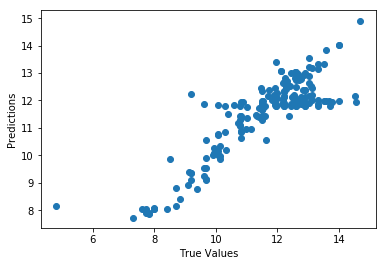

Score: 0.766435397871


In [48]:
## The line / model
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()
print('Score:', model.score(X_test, y_test))

In [49]:
## Cross val
# Perform 6-fold cross validation
scores = cross_val_score(model, modelingData, y, cv=6)
print('Cross-validated scores:', scores)

Cross-validated scores: [ 0.8066399   0.5962648   0.68254753  0.76060458  0.78903679  0.66000909]


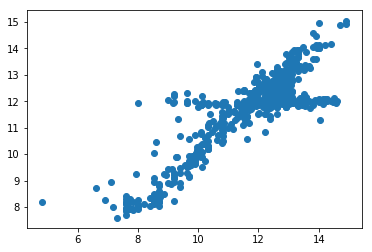

In [50]:
# Make cross validated predictions
predictions = cross_val_predict(model, modelingData, y, cv=6)
plt.scatter(y, predictions)
plt.show()

In [51]:
accuracy = metrics.r2_score(y, predictions)
print('Cross-Predicted Accuracy:', accuracy)

Cross-Predicted Accuracy: 0.729397999055


In [52]:
print(lm.coef_)
print(np.std(X_train,0)*lm.coef_)

[ 1.09548608 -0.00760733  0.01626902]
Number of turbines    1.420649
Altitude/Depth (m)   -0.159753
Hub height (m)        0.161970
dtype: float64


### Perceptron Clustering

For clustering, I will be binning average turbine power output and attempt to predict by bin.

To do this, I will first create the target variable by getting the average power output for a single turbine.

In [54]:
windFarms_Final_Bin = windFarms_Final.copy()
windFarms_Final_Bin['Output/turbine'] = np.where(windFarms_Final_Bin['Number of turbines'] < 1, 
                                             windFarms_Final_Bin['Number of turbines'], 
                                             windFarms_Final_Bin['Total power (kW)']/windFarms_Final_Bin['Number of turbines'])

In [55]:
windFarms_Final_Bin.shape

(643, 124)

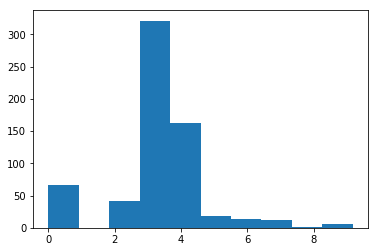

In [56]:
plt.hist(windFarms_Final_Bin['Output/turbine'])
plt.show()

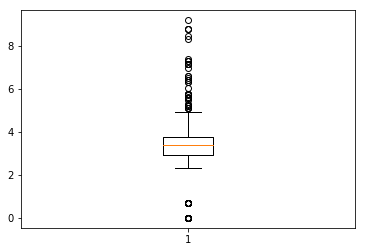

In [57]:
plt.boxplot(windFarms_Final_Bin['Output/turbine'])
plt.show()

> Using this new variable, I will bin the different power outputs:

    1) < 2   kw/turbine < 7.4
    2) 2-3   kw/turbine 7.4 - 20
    3) 3-4   kw/turbine 20.1 - 54.6
    4) 4-5   kw/turbine 54.7 - 148.4
    5) > 5   kw/turbine > 148.4 

In [58]:
windFarms_Final_Bin['Output Bin'] = np.where(windFarms_Final_Bin['Output/turbine'] <= 2, 1, 
                                          np.where(np.logical_and(windFarms_Final_Bin['Output/turbine'] > 2, 
                                                           windFarms_Final_Bin['Output/turbine'] <= 3), 2, 
                                                           np.where(np.logical_and(windFarms_Final_Bin['Output/turbine'] > 3,
                                                                        windFarms_Final_Bin['Output/turbine'] <= 4), 3, 
                                                                        np.where(np.logical_and(windFarms_Final_Bin['Output/turbine'] > 4,
                                                                                       windFarms_Final_Bin['Output/turbine'] <= 5), 4, 5))))

In [59]:
# Check to see how many observations are in each bin
BinCounts = windFarms_Final_Bin.copy()
BinCounts.groupby(['Output Bin']).size().reset_index(name='counts')

,Output Bin,counts
0,1,66
1,2,134
2,3,349
3,4,52
4,5,42


In [60]:
# Check to see if Bin variables were created correctly
windFarms_Final_Bin.head()

,Altitude/Depth (m),Hub height (m),Number of turbines,Total power (kW),Manufacturer_Adwen,Manufacturer_Alstom Power,Manufacturer_Areva,Manufacturer_Bard,Manufacturer_Bonus,Manufacturer_CSIC HZ Windpower,...,Turbine_WinDS3000/100,Turbine_WinDS3000/134,Turbine_WinDS3000/91,Turbine_XE/DD115,Status_Approved,Status_Construction,Status_Planned,Status_Production,Output/turbine,Output Bin
0,-15.0,94.0,1.791759,10.323841,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,5.761846,5
1,-5.0,64.0,2.995732,10.596635,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,3.537244,3
2,0.0,90.0,0.000000,8.006368,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0.000000,1
4,-4.0,65.0,1.945910,9.259131,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,4.758252,4
6,-10.0,69.0,2.708050,10.448715,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,3.858390,3


> Now that we have our bins, we will create our clustering model

In [61]:
# Two methods: 
#   1) Use all variables
#   2) Select only certain variables

### All variables
## Drop response var and output/turbine var from dataset
clustering_model1 = windFarms_Final_Bin.copy()
clustering_model1.pop('Output/turbine')
clustering_model1.pop('Output Bin')
print(clustering_model1.shape)
y = windFarms_Final_Bin['Output Bin']
print(y.shape)

### Only some variables
#clustering_model1 = clustering_model[['Altitude/Depth (m)', 'Hub height (m)']]
#print(clustering_model1.shape)
#y = clustering_model['Output Bin']
#print(y.shape)

(643, 123)
(643,)


In [74]:
# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(clustering_model1, y, test_size=0.3)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(450, 123) (450,)
(193, 123) (193,)


In [75]:
# Scaling
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [76]:
# After standardizing, we now tain a perceptron model
ppn = Perceptron(n_iter=40, eta0=0.1, random_state=0)
ppn.fit(X_train_std, y_train)

C:\Users\ahancock\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Perceptron(alpha=0.0001, class_weight=None, eta0=0.1, fit_intercept=True,
      max_iter=None, n_iter=40, n_jobs=1, penalty=None, random_state=0,
      shuffle=True, tol=None, verbose=0, warm_start=False)

In [77]:
# Use this model to make predictions
y_pred = ppn.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

Misclassified samples: 46
Accuracy: 0.76


> Of our 192 training samples, only 47 are missclassified giving us an accuracy score of 76%.

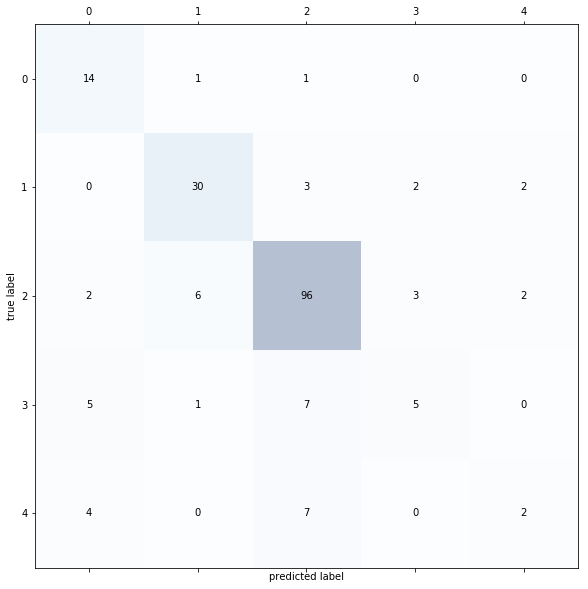

In [78]:
confmat = confusion_matrix(y_true = y_test, y_pred = y_pred)
#print(confmat)
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i,
                s=confmat[i, j],
                va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

In [58]:
# Visualize decision regions
## Note: Only run for testing of two vars ('Altitude/Depth (m)', 'Hub height (m)')

#def plot_decision_regions(X, y, classifier, test_idx = None, resolution = 0.02):
    # setup marker generator and color map
#    markers = ['s', 'x', 'o', '8', '^', 'v']
#    colors = ['red', 'blue', 'lightgreen', 'yellow', 'gray', 'cyan']
#    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # plot the decision surface
#    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
#    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
#    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
#                           np.arange(x2_min, x2_max, resolution))
#    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
#    Z = Z.reshape(xx1.shape)
#    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap = cmap)
#    plt.xlim(xx1.min(), xx1.max())
#    plt.ylim(xx2.min(), xx2.max())
    
    # plot all samples
#    for idx, cl in enumerate(np.unique(y)):
#        plt.scatter(x = X[y == cl, 0], y = X[y == cl, 1],
#                    alpha = 0.8, c=cmap(idx),
#                   marker = markers[idx], label = cl)
    
    # highlight test samples
#    if test_idx:
#        X_test, y_test = X[test_idx, :], y[test_idx]
#        plt.scatter(X_test[:, 0], X_test[:, 1], c = '',
#                    alpha = 1.0, linewidths = 1, marker = 'o',
#                    s = 55, label = 'test set')
        

#X_combined_std = np.vstack((X_train_std, X_test_std))
#y_combined = np.hstack((y_train, y_test))
#plot_decision_regions(X = X_combined_std,
#                      y = y_combined,
#                      classifier = ppn,
#                      test_idx = range(105, 150))
#plt.show()

### Support Vector Regression

In [142]:
from sklearn import svm
SVR_model = windFarms_Final_Bin.copy()
SVR_model.pop('Output/turbine')
SVR_model.pop('Output Bin')
print(SVR_model.shape)
y = windFarms_Final_Bin['Output/turbine']
print(y.shape)


# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(SVR_model, y, test_size=0.3)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)



clf = svm.SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
            kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
clf.fit(X_train, y_train) 

clf.predict(X_test)
clf.score(X_test, y_test)

(643, 123)
(643,)
(450, 123) (450,)
(193, 123) (193,)


0.13001156310932294

### K-Means (unsupervised)

Number of turbines, Depth, and hub height are the most predictive from linear regression. For unsuperised clustering I will be using Depth because the number of turbines will be used to calculate my response variable for supervised clustering and hub height had too many missing values filled with meadian.

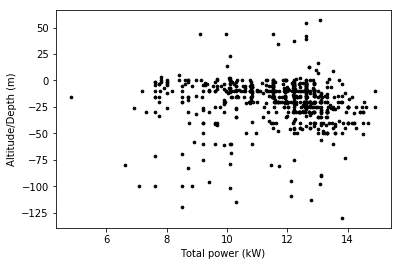

In [229]:
kmeans_model = windFarms_Final_Bin.copy()

f1 = kmeans_model['Total power (kW)'].values
f2 = kmeans_model['Altitude/Depth (m)'].values
X = np.array(list(zip(f1, f2)))
plt.scatter(f1, f2, c='black', s=7)
plt.xlabel('Total power (kW)')
plt.ylabel('Altitude/Depth (m)')
plt.show()

In [239]:
# Euclidean Distance Caculator
def dist(a, b, ax=1):
    return np.linalg.norm(a - b, axis=ax)

# Number of clusters
k = 5
# X coordinates of random centroids
C_x = np.random.randint(0, np.max(X)-30, size=k)
# Y coordinates of random centroids
C_y = np.random.randint(0, np.max(X)-30, size=k)
C = np.array(list(zip(C_x, C_y)), dtype=np.float32)
print(C)

[[  3.   1.]
 [ 18.  21.]
 [ 18.  22.]
 [ 21.   3.]
 [ 14.   5.]]


In [240]:
from copy import deepcopy

# To store the value of centroids when it updates
C_old = np.zeros(C.shape)
# Cluster Lables(0, 1, 2)
clusters = np.zeros(len(X))
# Error func. - Distance between new centroids and old centroids
error = dist(C, C_old, None)
# Loop will run till the error becomes zero
while error != 0:
    # Assigning each value to its closest cluster
    for i in range(len(X)):
        distances = dist(X[i], C)
        cluster = np.argmin(distances)
        clusters[i] = cluster
    # Storing the old centroid values
    C_old = deepcopy(C)
    # Finding the new centroids by taking the average value
    for i in range(k):
        points = [X[j] for j in range(len(X)) if clusters[j] == i]
        C[i] = np.mean(points, axis=0)
    error = dist(C, C_old, None)



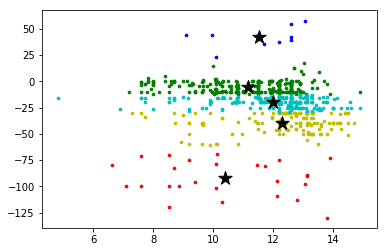

In [241]:
colors = ['r', 'g', 'b', 'y', 'c', 'm']
fig, ax = plt.subplots()
for i in range(k):
        points = np.array([X[j] for j in range(len(X)) if clusters[j] == i])
        ax.scatter(points[:, 0], points[:, 1], s=7, c=colors[i])
ax.scatter(C[:, 0], C[:, 1], marker='*', s=200, c='#050505')
plt.show()

> What I would have liked to have seen here would have been an increase in power output with an increase in depth. This would signify that companies are willing to go deeper to produce more power. This was not the case as the power output is relatively the same at each depth cluster.

In [242]:
# Fit model with 5 clusters
from sklearn.cluster import KMeans

km= KMeans(n_clusters=5)
y_km = km.fit_predict(X)

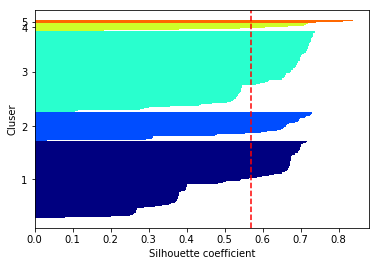

In [247]:
# Silhouette plot
from matplotlib import cm
from sklearn.metrics import silhouette_samples
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(i / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),
             c_silhouette_vals,
             height = 1.0,
             edgecolor = 'none',
             color = color)
    yticks.append((y_ax_lower + y_ax_upper) / 2)
    y_ax_lower += len(c_silhouette_vals)
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg,
            color = 'red',
            linestyle = '--')
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluser')
plt.xlabel('Silhouette coefficient')
plt.show()

> While the silhouette coefficients are relatively the same, we can see from their widths that our clusters are not of equal size.

### Decision Trees

In [59]:
# Prep dataframe for modeling

# Two methods: 
#   1) Use all variables
#   2) Select only certain variables


## Drop response var and output/turbine var from dataset
#DecisionTree_model = windFarms_Final_Bin.copy()
#DecisionTree_model.pop('Output/turbine')
#DecisionTree_model.pop('Output Bin')
#print(DecisionTree_model.shape)
#y = windFarms_Final_Bin['Output Bin']
#print(y.shape)

# Need to binarize
#y = label_binarize(y, classes = [1,2,3,4,5])

### Only some variables
DecisionTree_model = windFarms_Final_Bin[['Altitude/Depth (m)', 'Hub height (m)']]
print(DecisionTree_model.shape)
y = windFarms_Final_Bin['Output Bin']
print(y.shape)

# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(DecisionTree_model, y, test_size=0.3)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(640, 2)
(640,)
(448, 2) (448,)
(192, 2) (192,)


In [60]:
# Build Decision Tree
tree = DecisionTreeClassifier(criterion='entropy', max_depth = 5, random_state = 0)
tree.fit(X_train, y_train)

# Use this model to make predictions
y_pred = tree.predict(X_test)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

Misclassified samples: 91
Accuracy: 0.53


> Used only Depth and Hub Height for decision tree because these seemed like good predictors of power output, but wth an accuracy score of 54% this wasn't a very useful model. I thought these would be good variables because the deeper the depth or the taller the hub height the more expensive the project would be. A company would only spend more money on a project if the return on investment makes sens (e.g. larger power output per turbine).

In [61]:
# Display decision tree
# Couldn't get this to work

#from sklearn.externals.six import StringIO
#tree_dot = StringIO()
#export_graphviz(tree, out_file=tree_dot, feature_names = ['Altitude/depth (m)', 'Hub height (m)'])
#import pydotplus
#from IPython.display import Image
#graph = pydotplus.graph_from_dot_data(tree_dot.getvalue())  
#Image(graph.create_png())

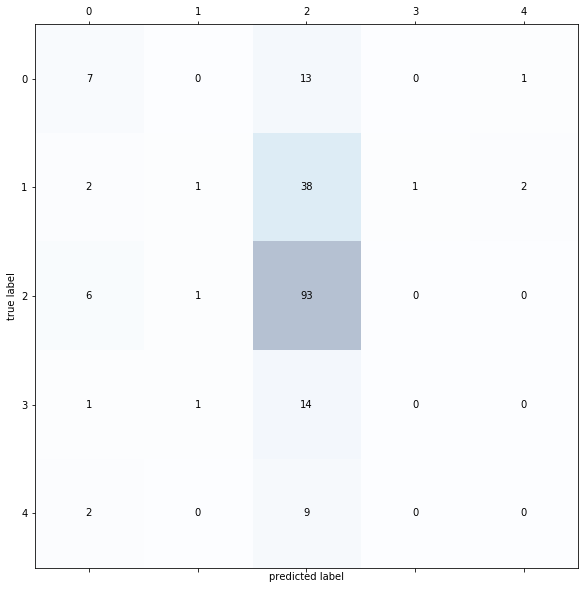

In [62]:
confmat = confusion_matrix(y_true = y_test, y_pred = y_pred)
#print(confmat)
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i,
                s=confmat[i, j],
                va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

#### Random Forest

In [63]:
# Random Forest

### Only some variables
RandomForest_model = windFarms_Final_Bin[['Altitude/Depth (m)', 'Hub height (m)']]
print(RandomForest_model.shape)
y = windFarms_Final_Bin['Output Bin']
print(y.shape)

# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(RandomForest_model, y, test_size=0.3)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(criterion = 'entropy', n_estimators = 100, random_state = 1, n_jobs = 2)
forest.fit(X_train, y_train)

# Use this model to make predictions
y_pred = forest.predict(X_test)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

(640, 2)
(640,)
(448, 2) (448,)
(192, 2) (192,)
Misclassified samples: 102
Accuracy: 0.47


> Random Forest was a little better with an accuracy score of 58%.

In [64]:
#https://stackoverflow.com/questions/22361781/how-does-sklearn-random-forest-index-feature-importances
importances = pd.DataFrame({'feature':X_train.columns, 'importance': forest.feature_importances_}) 
importances = importances.sort_values('importance',ascending=False)#.set_index('feature') 
 
#only display top 20 importances[:10].plot.bar()
topDF1 = importances.head(20)
print(topDF1)

f, ax = plt.subplots(figsize=(15, 6))

g = sns.barplot('feature', y="importance", data=topDF1, color="red", saturation=.9, ci=68)
g =plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('importance')
plt.title('Random Forest Features importance')

              feature  importance
0  Altitude/Depth (m)     0.71259
1      Hub height (m)     0.28741


Text(0.5,1,'Random Forest Features importance')

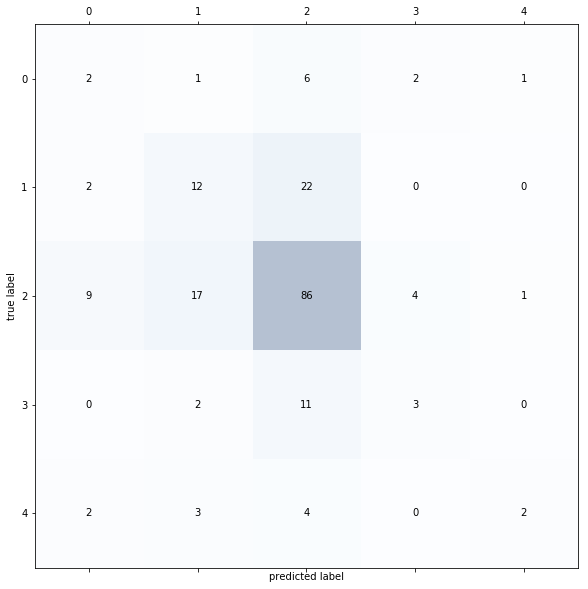

In [70]:
confmat = confusion_matrix(y_true = y_test, y_pred = y_pred)
#print(confmat)
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i,
                s=confmat[i, j],
                va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

### KNN Classifier

In [65]:
# Prep dataframe for modeling

## Drop response var and output/turbine var from dataset
knn_model = windFarms_Final_Bin.copy()
knn_model.pop('Output/turbine')
knn_model.pop('Output Bin')
print(knn_model.shape)
y = windFarms_Final_Bin['Output Bin']
print(y.shape)

# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(knn_model, y, test_size=0.3)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(640, 123)
(640,)
(448, 123) (448,)
(192, 123) (192,)


In [66]:
# Build Decision Tree
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 5, p = 2, metric = 'minkowski')
knn.fit(X_train, y_train)

# Use this model to make predictions
y_pred = knn.predict(X_test)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

Misclassified samples: 76
Accuracy: 0.60


> KNN classifier did better than the Random forest with an accuracy of 67%, but not as well as the Perceptron model at 76%.

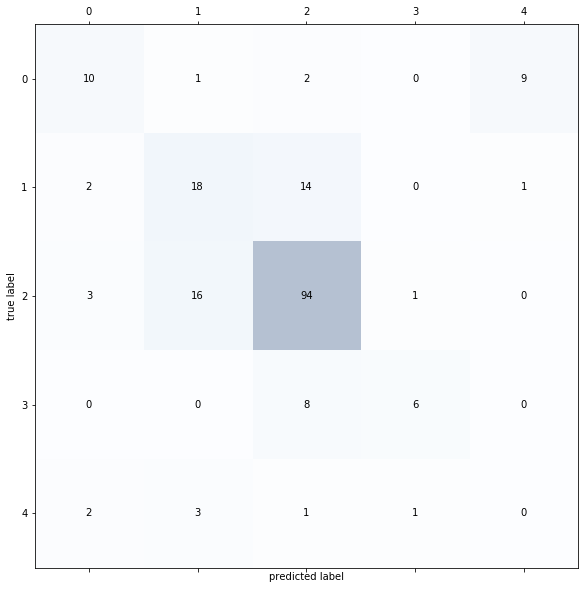

In [73]:
confmat = confusion_matrix(y_true = y_test, y_pred = y_pred)
#print(confmat)
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i,
                s=confmat[i, j],
                va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

### Ensemble Methods

#### Majority Vote

In [82]:
# Build the majority vote classifier

# Necessary packages and functions
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six # For compatability issues
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import operator

# Majority Vote Classifier implementation
## Allows us to bring in each classifier's parameters as well as the method to get accuracy score
class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, classifiers, vote = 'classlabel', weights = None):
        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
        
    def fit(self, X, y):
        # Use LabelEncoder to ensure class labels start with 0, which is important...
        # ...for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    
    # Predicts class by majority vote if vote = 'classlabel'
    # Predicts class by membership probabilities if vote = 'probability'
    def predict(self, X):
        if self.vote == "probability":
            maj_vote = np.argmax(self.predict_proba(X), axis = 1)
        else: # 'classlabel' vote
            # Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x, 
                                                                            weights = self.weights)),
                                           axis = 1, 
                                           arr = predictions)
            maj_vote = self.lablenc_.inverse_transform(maj_vote)
            return maj_vote
    
    # Return the average probilities, for ROC AUC
    def predict_proba(self, X):
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba = np.average(probas, 
                               axis = 0,
                               weights = self.weights)
        return avg_proba
    
    # Get individual classifier parameters
    def get_params(self, deep = True):
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep = False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep = True)):
                    out['%s__%s' % (name, key)] = value
            return out

In [116]:
# Prep dataframe for modeling

## Drop response var and output/turbine var from dataset
ensemble_model = windFarms_Final_Bin.copy()
ensemble_model_new = windFarms_Final_Bin.copy()

# Can't perform roc_auc on multiclass problems...
# ...need to select only 2 bins
ensemble_model_new['Power Output > 3.5'] = np.where(ensemble_model['Output/turbine'] > 3.5, 1, 0)
ensemble_model.pop('Output/turbine')
ensemble_model.pop('Output Bin')
ensemble_model.pop('Number of turbines')
ensemble_model.pop('Total power (kW)')
print(ensemble_model.shape)
y = ensemble_model_new['Power Output > 3.5']
print(y.shape)

# Need to binarize
#y = label_binarize(y, classes = [1,2,3,4,5])


# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(ensemble_model, y, test_size=0.3)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(640, 121)
(640,)
(448, 121) (448,)
(192, 121) (192,)


In [113]:
# Check to see how many observations are in each bin
BinCounts2 = windFarms_Final_Bin.copy()
BinCounts2['Power Output > 3.5'] = np.where(BinCounts2['Output/turbine'] > 3.5, 1, 0)
BinCounts2.groupby(['Power Output > 3.5']).size().reset_index(name='counts')

,Power Output > 3.5,counts
0,0,343
1,1,297


In [104]:
np.exp(3.5)

33.115451958692312

In [105]:
### Note: I tested with these, but for the ensemeble model I used previous methods

# Train different classifiers
#from sklearn.linear_model import LogisticRegression
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.pipeline import Pipeline

#clf1 = LogisticRegression(#penalty = '12',
#                          C = 0.001,
#                          random_state = 0)

#clf2 = DecisionTreeClassifier(max_depth = 1,
#                             criterion = 'entropy',
#                             random_state = 0)

#clf3 = KNeighborsClassifier(n_neighbors = 1,
#                           p = 1,
#                           metric = 'minkowski')

# Don't need pipeline for DecisionTree because it doesn't have to be scaled
#pipe1 = Pipeline([['sc', StandardScaler()],
#                  ['clf', clf1]])
#pipe3 = Pipeline([['sc', StandardScaler()],
#                  ['clf', clf3]])

#clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN']
#print('10-fold cross validation:\n')
#for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
#    scores = cross_val_score(estimator=clf,
#                             X = X_train,
#                             y = y_train,
#                             cv = 10,
#                             scoring = 'roc_auc')
#    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

In [117]:
mv_clf = MajorityVoteClassifier(classifiers = [tree, forest, knn])
clf_labels = ['Decision Tree', 'Random Forest', 'KNN','Majority Voting']
all_clf = [tree, forest, knn, mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X = X_train,
                             y = y_train,
                             cv = 10,
                             scoring = 'roc_auc')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.64 (+/- 0.07) [Decision Tree]
Accuracy: 0.68 (+/- 0.07) [Random Forest]
Accuracy: 0.63 (+/- 0.08) [KNN]
Accuracy: 0.69 (+/- 0.07) [Majority Voting]


#### Bagging

In [161]:
# Prep dataframe for modeling

## Drop response var and output/turbine var from dataset
bagging_model = windFarms_Final_Bin.copy()
bagging_model_new = windFarms_Final_Bin.copy()

bagging_model_new['Power Output > 3.5'] = np.where(bagging_model['Output/turbine'] > 3.5, 1, 0)

### Only some variables
bagging_model = bagging_model[['Altitude/Depth (m)', 'Hub height (m)']].values
print(bagging_model.shape)
y = bagging_model_new['Power Output > 3.5']
print(y.shape)


# Need to binarize
le = LabelEncoder()
y = le.fit_transform(y)

# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(bagging_model, y, test_size=0.3)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(640, 2)
(640,)
(448, 2) (448,)
(192, 2) (192,)


In [162]:
# Create ensemble of 500 decision trees fitted to bootstrap samples

from sklearn.ensemble import BaggingClassifier
tree = DecisionTreeClassifier(criterion = 'entropy',
                              max_depth = None,
                              random_state = 1)
bag = BaggingClassifier(base_estimator=tree,
                        n_estimators = 500,
                        max_samples = 1.0,
                        max_features = 1.0,
                        bootstrap = True,
                        bootstrap_features = False,
                        n_jobs = 1,
                        random_state = 1)

In [163]:
# Calculate accuracy score of a single tree
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f' % (tree_train, tree_test))

Decision tree train/test accuracies 0.741/0.604


In [164]:
# Claculate accuray score of bagging
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print('Bagging train/test accuracies %.3f/%.3f' % (bag_train, bag_test))

Bagging train/test accuracies 0.741/0.615


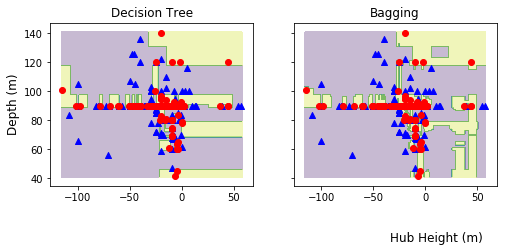

In [165]:
# Decision regions
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=1, ncols=2,
                        sharex='col',
                        sharey='row',
                        figsize=(8,3))
for idx, clf, tt in zip([0,1],
                        [tree, bag],
                        ['Decision Tree', 'Bagging']):
    clf.fit(X_train, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha = 0.3)
    axarr[idx].scatter(X_train[y_train==0, 0],
                       X_train[y_train==0, 1],
                       c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train==1, 0],
                       X_train[y_train==1, 1],
                       c='red', marker='o')
    axarr[idx].set_title(tt)
axarr[0].set_ylabel('Depth (m)', fontsize=12)
plt.text(10.2, -1.2, s='Hub Height (m)', ha='center', va='center',fontsize=12)
plt.show()